In [1]:
import os
import shutil  # https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive  # to unzip
# from shutil import make_archive # to create zip for storage
import requests  # for downloading zip file
from scipy import io  # for loadmat, matlab conversion
import numpy as np

# credit https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url
# many other methods I tried failed to download the file properly


def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)


def unimib_load_dataset(
        verbose=True,
        incl_xyz_accel=False,  # include component accel_x/y/z in ____X data
        # add rms value (total accel) of accel_x/y/z in ____X data
        incl_rms_accel=True,
        incl_val_group=False,  # True => returns x/y_test, x/y_validation, x/y_train
    # False => combine test & validation groups
        split_subj=dict
    (train_subj=[4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 19, 20, 21, 22, 24, 26, 27, 29],
     validation_subj=[1, 9, 16, 23, 25, 28],
     test_subj=[2, 3, 13, 17, 18, 30]),
        one_hot_encode=True):

    # Download and unzip original dataset
    if (not os.path.isfile('./UniMiB-SHAR.zip')):
        print("Downloading UniMiB-SHAR.zip file")
        # invoking the shell command fails when exported to .py file
        # redirect link https://www.dropbox.com/s/raw/x2fpfqj0bpf8ep6/UniMiB-SHAR.zip
        #!wget https://www.dropbox.com/s/x2fpfqj0bpf8ep6/UniMiB-SHAR.zip
        download_url(
            'https://www.dropbox.com/s/raw/x2fpfqj0bpf8ep6/UniMiB-SHAR.zip', './UniMiB-SHAR.zip')
    if (not os.path.isdir('./UniMiB-SHAR')):
        shutil.unpack_archive('./UniMiB-SHAR.zip', '.', 'zip')
    # Convert .mat files to numpy ndarrays
    path_in = './UniMiB-SHAR/data'
    # loadmat loads matlab files as dictionary, keys: header, version, globals, data
    adl_data = io.loadmat(path_in + '/adl_data.mat')['adl_data']
    adl_names = io.loadmat(path_in + '/adl_names.mat',
                           chars_as_strings=True)['adl_names']
    adl_labels = io.loadmat(path_in + '/adl_labels.mat')['adl_labels']

    # Reshape data and compute total (rms) acceleration
    num_samples = 151
    # UniMiB SHAR has fixed size of 453 which is 151 accelX, 151 accely, 151 accelz
    adl_data = np.reshape(adl_data, (-1, num_samples, 3),
                          order='F')  # uses Fortran order
    if (incl_rms_accel):
        rms_accel = np.sqrt(
            (adl_data[:, :, 0]**2) + (adl_data[:, :, 1]**2) + (adl_data[:, :, 2]**2))
        adl_data = np.dstack((adl_data, rms_accel))

    # remove component accel if needed
    if (not incl_xyz_accel):
        adl_data = np.delete(adl_data, [0, 1, 2], 2)

    # matlab source was 1 indexed, change to 0 indexed
    act_num = (adl_labels[:, 0])-1
    sub_num = (adl_labels[:, 1])  # subject numbers are in column 1 of labels

    if (not incl_val_group):
        train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj'] +
                                         split_subj['validation_subj']))
        x_train = adl_data[train_index]
        y_train = act_num[train_index]
    else:
        train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj']))
        x_train = adl_data[train_index]
        y_train = act_num[train_index]

        validation_index = np.nonzero(
            np.isin(sub_num, split_subj['validation_subj']))
        x_validation = adl_data[validation_index]
        y_validation = act_num[validation_index]

    test_index = np.nonzero(np.isin(sub_num, split_subj['test_subj']))
    x_test = adl_data[test_index]
    y_test = act_num[test_index]

    if (verbose):
        print("x/y_train shape ", x_train.shape, y_train.shape)
    if (incl_val_group):
        print("x/y_validation shape ", x_validation.shape, y_validation.shape)
    print("x/y_test shape  ", x_test.shape, y_test.shape)

    if (incl_val_group):
        return x_train, y_train, x_validation, y_validation, x_test, y_test
    else:
        return x_train, y_train, x_test, y_test

In [2]:
X_train, y_train, X_valid, y_valid, X_test, y_test = unimib_load_dataset(
    incl_xyz_accel=True, incl_val_group=True, one_hot_encode=False, verbose=True
)

# Number of classes
n_classes = len(np.unique(y_train))
print(f"Number of classes: {n_classes}")

x/y_train shape  (4601, 151, 4) (4601,)
x/y_validation shape  (1454, 151, 4) (1454,)
x/y_test shape   (1524, 151, 4) (1524,)
Number of classes: 9


In [4]:
!pip install torchinfo

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary

In [6]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(y_train, dtype=torch.int64)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
Y_valid = torch.tensor(y_valid, dtype=torch.int64)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(y_test, dtype=torch.int64)

# DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

valid_dataset = TensorDataset(X_valid, Y_valid)
valid_loader = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [7]:
import math

class TimeSeriesPatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim, input_timesteps):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels

        # Calculate the number of patches, adjusting for padding if necessary
        # Ceiling division to account for padding
        self.num_patches = -(-input_timesteps // patch_size)
        self.padding = (
            self.num_patches * patch_size
        ) - input_timesteps  # Calculate padding length

        self.conv_layer = nn.Conv1d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )

        self.class_token_embeddings = nn.Parameter(
            torch.randn((1, 1, embedding_dim), requires_grad=True)
        )
        self.position_embeddings = PositionalEncoding(embedding_dim, dropout=0.1, max_len=input_timesteps)

    def forward(self, x):
        # Pad the input sequence if necessary
        if self.padding > 0:
            x = nn.functional.pad(x, (0, 0, 0, self.padding))  # Pad the second to last dimension, which is input_timesteps

        # We use a Conv1d layer to generate the patch embeddings
        x = x.permute(0, 2, 1)  # (batch, features, timesteps)
        conv_output = self.conv_layer(x)
        conv_output = conv_output.permute(0, 2, 1)  # (batch, timesteps, features)

        batch_size = x.shape[0]
        class_tokens = self.class_token_embeddings.expand(batch_size, -1, -1)
        output = torch.cat((class_tokens, conv_output), dim=1)

        output = self.position_embeddings(output)

        return output


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

    def pos_encoding(self, q_len, d_model, normalize=True):
        pe = torch.zeros(q_len, d_model)
        position = torch.arange(0, q_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        if normalize:
            pe = pe - pe.mean()
            pe = pe / (pe.std() * 10)
        return pe

    def forward(self, x):
        x = x + self.pos_encoding(q_len = x.size(1), d_model = x.size(2))
        return self.dropout(x)

In [8]:
random_instances, random_labels = next(iter(train_loader))
random_instance = random_instances[0]

BATCH_SIZE = random_instances.shape[0]
TIMESTEPS = random_instance.shape[0]
CHANNELS = random_instance.shape[1]
PATCH_SIZE = 8

patch_embedding_layer = TimeSeriesPatchEmbeddingLayer(
    in_channels=CHANNELS,
    patch_size=PATCH_SIZE,
    embedding_dim=CHANNELS * PATCH_SIZE,
    input_timesteps=TIMESTEPS,
)

patch_embeddings = patch_embedding_layer(random_instances)
patch_embeddings.shape

summary(
    model=patch_embedding_layer,
    # (batch_size, input_channels, input_timesteps)
    input_size=(BATCH_SIZE, TIMESTEPS, CHANNELS),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
TimeSeriesPatchEmbeddingLayer (TimeSeriesPatchEmbeddingLayer)     [64, 151, 4]         [64, 20, 32]         32                   True
├─Conv1d (conv_layer)                                             [64, 4, 152]         [64, 32, 19]         1,056                True
├─PositionalEncoding (position_embeddings)                        [64, 20, 32]         [64, 20, 32]         --                   --
│    └─Dropout (dropout)                                          [64, 20, 32]         [64, 20, 32]         --                   --
Total params: 1,088
Trainable params: 1,088
Non-trainable params: 0
Total mult-adds (M): 1.28
Input size (MB): 0.15
Forward/backward pass size (MB): 0.31
Params size (MB): 0.00
Estimated Total Size (MB): 0.47

In [9]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_timesteps, in_channels, patch_size, embedding_dim, num_transformer_layers=6, num_heads=8, dim_feedforward=128, dropout=0.1, num_classes=2):
        super().__init__()

        # Embedding layer
        self.patch_embedding = TimeSeriesPatchEmbeddingLayer(in_channels, patch_size, embedding_dim, input_timesteps)

        # Calculate the number of patches
        self.num_patches = -(-input_timesteps // patch_size)

        # Transformer Encoder
        # Setting batch_first=True to accommodate inputs with batch dimension first
        encoder_layers = TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layer=encoder_layers, num_layers=num_transformer_layers)

        # Feedforward layer
        self.ff_layer = nn.Linear(embedding_dim, dim_feedforward)
        # Classifier Head
        self.classifier = nn.Linear(dim_feedforward, num_classes)

    def forward(self, x):
        # x shape: (batch_size, in_channels, input_timesteps)

        # Get patch embeddings
        x = self.patch_embedding(x)  # Output shape: (batch_size, num_patches + 1, embedding_dim)

        # Apply Transformer Encoder with batch first
        x = self.transformer_encoder(x)  # Output shape: (batch_size, num_patches + 1, embedding_dim)

        # Use the output corresponding to the class token for classification
        class_token_output = x[:, 0, :]  # Select the class token for each item in the batch

        # Feedforward layer
        x = self.ff_layer(class_token_output)

        # Classifier head
        output = self.classifier(x)  # Output shape: (batch_size, num_classes)

        return output


In [10]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = TimeSeriesTransformer(
    input_timesteps=TIMESTEPS,
    in_channels=CHANNELS,
    patch_size=8,
    embedding_dim=32,
    num_transformer_layers=4,
    num_heads=4,
    dim_feedforward=128,
    dropout=0.2,
    num_classes=n_classes,
).to(device)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler to reduce the learning rate by the specified step size and factor (gamma) every step_size epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

summary(
    model=model,
    input_size=(BATCH_SIZE, TIMESTEPS, CHANNELS),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TimeSeriesTransformer (TimeSeriesTransformer)           [64, 151, 4]         [64, 9]              --                   True
├─TimeSeriesPatchEmbeddingLayer (patch_embedding)       [64, 151, 4]         [64, 20, 32]         32                   True
│    └─Conv1d (conv_layer)                              [64, 4, 152]         [64, 32, 19]         1,056                True
│    └─PositionalEncoding (position_embeddings)         [64, 20, 32]         [64, 20, 32]         --                   --
│    │    └─Dropout (dropout)                           [64, 20, 32]         [64, 20, 32]         --                   --
├─TransformerEncoder (transformer_encoder)              [64, 20, 32]         [64, 20, 32]         --                   True
│    └─ModuleList (layers)                              --                   --                   --                   True
│    │ 

In [11]:
# Model, loss function, and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Number of epochs
n_epochs = 20

# Initialize variables for tracking the best model
best_validation_acc = 0.0
best_model_path = 'best_model_v2.pth'

for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    train_losses = []
    train_correct = 0
    total = 0

    # Training loop
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients

        predictions = model(inputs)  # Forward pass
        loss = criterion(predictions, labels)  # Calculate loss

        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        train_losses.append(loss.item())

        # Count the number of correct predictions
        train_correct += (predictions.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = np.mean(train_losses)
    train_acc = train_correct / total

    # Validation loop
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        validation_losses = []
        validation_correct = 0
        total_val = 0

        for inputs, labels in valid_loader:
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            validation_losses.append(loss.item())

            validation_correct += (predictions.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

        validation_loss = np.mean(validation_losses)
        validation_acc = validation_correct / total_val

    # Check if this is the best model so far
    if validation_acc > best_validation_acc:
        best_validation_acc = validation_acc
        # Save the model
        torch.save(model.state_dict(), best_model_path)
        print(f'Epoch {epoch+1}: New best model saved with validation accuracy: {validation_acc:.4f}')

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {validation_loss:.4f}, Val Acc: {validation_acc:.4f}')

# Loading the best model
model.load_state_dict(torch.load(best_model_path))
print('Loaded best model for testing or further use.')

Epoch 1: New best model saved with validation accuracy: 0.4766
Epoch 1, Train Loss: 1.6517, Train Acc: 0.3893, Val Loss: 1.2955, Val Acc: 0.4766
Epoch 2: New best model saved with validation accuracy: 0.5263
Epoch 2, Train Loss: 1.1939, Train Acc: 0.5434, Val Loss: 1.1885, Val Acc: 0.5263
Epoch 3: New best model saved with validation accuracy: 0.5320
Epoch 3, Train Loss: 1.0193, Train Acc: 0.6039, Val Loss: 1.2932, Val Acc: 0.5320
Epoch 4: New best model saved with validation accuracy: 0.5945
Epoch 4, Train Loss: 0.8894, Train Acc: 0.6402, Val Loss: 1.0401, Val Acc: 0.5945
Epoch 5: New best model saved with validation accuracy: 0.6378
Epoch 5, Train Loss: 0.7771, Train Acc: 0.6959, Val Loss: 1.0070, Val Acc: 0.6378
Epoch 6: New best model saved with validation accuracy: 0.6925
Epoch 6, Train Loss: 0.6753, Train Acc: 0.7313, Val Loss: 0.8943, Val Acc: 0.6925
Epoch 7, Train Loss: 0.6077, Train Acc: 0.7586, Val Loss: 0.7751, Val Acc: 0.6747
Epoch 8: New best model saved with validation ac

In [12]:
# Prediction
model.eval()
with torch.no_grad():
    Y_pred_prob = model(X_test)

Y_pred = Y_pred_prob.argmax(1)

print(classification_report(Y_test, Y_pred))
confusion = confusion_matrix(Y_test, Y_pred)
print(f"Confusion matrix:\n{confusion}")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.31      0.43      0.36        47
           2       0.67      1.00      0.81       344
           3       0.97      0.92      0.94       413
           4       0.68      0.38      0.49       184
           5       1.00      0.89      0.94       146
           6       0.81      0.61      0.70       256
           7       0.52      0.91      0.66        68
           8       0.46      0.19      0.27        32

    accuracy                           0.77      1524
   macro avg       0.60      0.59      0.57      1524
weighted avg       0.77      0.77      0.75      1524

Confusion matrix:
[[  0  20   0   0   0   0   0  12   2]
 [  1  20   0   0   0   0   0  25   1]
 [  0   0 344   0   0   0   0   0   0]
 [  0   0   4 378   0   0  31   0   0]
 [  0  13  93   0  70   0   6   0   2]
 [  0   0   1  11   2 130   1   0   1]
 [  0   0  68   0  31   0 157   0   0]
 [  

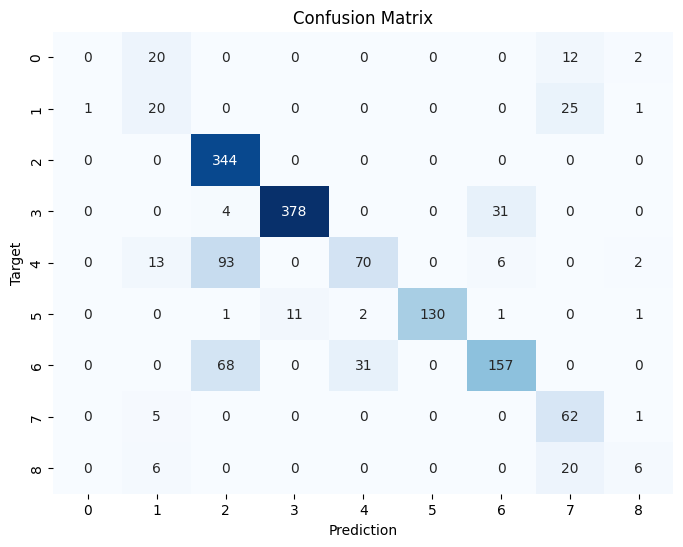

In [13]:
# Visualize the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.title("Confusion Matrix")
plt.show()